In [1]:
import sys
sys.path.append("/home/jarlehti/projects/gradu")

In [7]:
import os
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import d3p
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import linalg
import glob
import scipy.stats as stats
import itertools
from pprint import pprint
from scripts.constants import COLUMNS_FOR_DATASET
from src.utils.data_utils import transform_for_modeling
from scripts.constants import TEST_DATASETS_FOR_DATASET, TARGET_COLUMNS_FOR_DATASET
from src.napsu_mq.napsu_mq import NapsuMQModel, NapsuMQResult

In [3]:
CURRENT_FOLDER = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
RESULTS_FOLDER = os.path.join(CURRENT_FOLDER, "results")
PLOTS_FOLDER = os.path.join(CURRENT_FOLDER, "plots")

In [4]:
ci_coverage_files = glob.glob(os.path.join(RESULTS_FOLDER, 'ci_coverage_napsu_independence_pruning_*.csv'))

In [5]:
df_combined = pd.DataFrame()

for file in sorted(ci_coverage_files):
    df = pd.read_csv(file)
    df_combined = df_combined.append(df)

/tmp/ipykernel_1184975/3890474617.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = df_combined.append(df)
/tmp/ipykernel_1184975/3890474617.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = df_combined.append(df)
/tmp/ipykernel_1184975/3890474617.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = df_combined.append(df)
/tmp/ipykernel_1184975/3890474617.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = df_combined.append(df)
/tmp/ipykernel_1184975/3890474617.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pa

/tmp/ipykernel_1184975/3890474617.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = df_combined.append(df)
/tmp/ipykernel_1184975/3890474617.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = df_combined.append(df)
/tmp/ipykernel_1184975/3890474617.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = df_combined.append(df)
/tmp/ipykernel_1184975/3890474617.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = df_combined.append(df)
/tmp/ipykernel_1184975/3890474617.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pa

In [6]:
df_combined['parameter_index'] = df_combined.groupby(['true_parameter_value'], sort=False).ngroup() + 1

In [14]:
df_combined

,original_dataset_name,index,n_datasets,conf_int_range,conf_int_start,conf_int_end,conf_int_width,true_parameter_value,contains_true_parameter,missing_query,experiment_id,epsilon,parameter_index
0,adult_independence_pruning,0,100,0.05,-0.105486,-0.057569,0.047917,0.008048,False,age+compensation,PYQ6IL0P,0.1,1
1,adult_independence_pruning,0,100,0.05,-0.053235,-0.049226,0.004010,-0.107231,False,age+compensation,PYQ6IL0P,0.1,2
2,adult_independence_pruning,0,100,0.05,-0.527967,-0.493845,0.034123,0.082457,False,age+compensation,PYQ6IL0P,0.1,3
3,adult_independence_pruning,0,100,0.05,-0.091445,-0.039914,0.051531,0.644892,False,age+compensation,PYQ6IL0P,0.1,4
4,adult_independence_pruning,0,100,0.10,-0.149637,-0.062081,0.087555,0.008048,False,age+compensation,PYQ6IL0P,0.1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3795,adult_independence_pruning,49,100,0.90,0.586223,0.727110,0.140888,0.644892,True,none,2WELYLDZ,8.0,4
3796,adult_independence_pruning,49,100,0.95,-0.055520,0.103562,0.159083,0.008048,True,none,2WELYLDZ,8.0,1
3797,adult_independence_pruning,49,100,0.95,-0.112661,-0.102983,0.009678,-0.107231,True,none,2WELYLDZ,8.0,2
3798,adult_independence_pruning,49,100,0.95,0.028355,0.133326,0.104971,0.082457,True,none,2WELYLDZ,8.0,3


In [9]:
dataset_name = "adult_independence_pruning"

train_df_path = os.path.join(CURRENT_FOLDER, f"data/datasets/{dataset_name}.csv")
train_df = pd.read_csv(train_df_path)

train_df_transformed = transform_for_modeling(dataset_name, train_df)

In [10]:
rng = jax.random.PRNGKey(42)
model = NapsuMQModel()

n, d = train_df_transformed.shape

meta = model.fit(
    data=train_df_transformed,
    dataset_name="adult_independence_pruning",
    rng=rng,
    epsilon=8,
    delta=(n ** (-2)),
    column_feature_set=[],
    use_laplace_approximation=True,
    laplace_approximation_algorithm="torch_LBFGS",
    dry_run=True,
    return_MST_weights=True
)

MST_weights = meta['MST_weights']

No experiment_id found: <ContextVar name='experiment_id' at 0x7feadcc7b540>
Setting experiment_id to GORHJ98R
Domain size: 256
Recording:  Query selection
start MST selection
end MST selection
Recording:  Calculating full marginal query
MST query set: [('age', 'education-num'), ('education-num', 'compensation'), ('sex', 'compensation'), ('sex', 'hours-per-week')]
Recording:  Calculating canonical query set
Calculating canonical queries, clique_set length: 10


  0%|                                                                                                                | 0/10 [00:00<?, ?it/s]
32it [00:00, 18199.01it/s]

4it [00:00, 11096.04it/s]

2it [00:00, 10866.07it/s]

2it [00:00, 4984.32it/s]

32it [00:00, 32577.12it/s]

4it [00:00, 20585.54it/s]

16it [00:00, 31227.95it/s]

2it [00:00, 6232.25it/s]

2it [00:00, 15857.48it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 69042.04it/s]


Calculating new queries, not_original_clique_queries length: 19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 46011.42it/s]

Canonical queries: 51
Junction tree width: 1
(51,)
2.235812976641374


DP noise mean: 0.10167308204221397
[4.98992268e+01 6.96191874e+01 2.24267501e+02 1.07708506e+02
 1.86164387e+02 1.12123978e+02 4.28402228e+01 1.43488293e+03
 7.46636960e+02 1.27438239e+02 7.72707485e+01 5.67791238e+02
 2.74037302e+02 1.00277724e+02 9.79838986e+01 1.08782118e+02
 2.22094322e+02 3.32529742e+02 3.50721531e+02 6.34810334e+02
 9.26465998e+02 3.40405390e+02 8.40644532e+03 5.93717498e+03
 1.18004753e+03 9.29397954e+02 4.47355585e+03 1.34850967e+03
 4.41307601e+02 2.73409644e+02 8.27888669e+00 6.39596368e+03
 1.39838738e+04 9.51522197e+00 1.48989943e+01 3.47671661e+01
 2.62729716e+01 5.71256559e+01 5.96339336e+01 2.83683465e+01
 1.61721395e+03 1.34293559e+03 3.39008892e+02 2.55658646e+02
 2.12358638e+03 9.15461829e+02 4.03840360e+02 2.80076708e+02
 1.88766028e+00 2.94031342e+03 5.31903168e+02]
SUFF STAT MEANS
1205.686274509804
1205.787947591846
SUFF STAT VARIANCES
6207849.744713571
6206957.942634349


In [11]:
sorted_MST_weights = sorted(MST_weights.items(), key=lambda item: item[1], reverse=True)

In [12]:
sorted_MST_weights

[(('education-num', 'compensation'), 7449.893588586523),
 (('sex', 'compensation'), 5295.358381864295),
 (('sex', 'hours-per-week'), 2384.468181321692),
 (('hours-per-week', 'compensation'), 2339.0671712857766),
 (('age', 'education-num'), 1993.9354415878202),
 (('education-num', 'sex'), 1879.1105626806807),
 (('education-num', 'hours-per-week'), 1566.8809860573579),
 (('age', 'compensation'), 1100.961534528216),
 (('age', 'sex'), 517.8815035084192),
 (('age', 'hours-per-week'), 213.04218712131728)]

In [32]:
sorted_MST_weights_map = dict(sorted_MST_weights)

In [30]:
sorted_MST_weights = [("+".join(sorted(pair[0])), pair[1]) for pair in sorted_MST_weights]

In [31]:
sorted_MST_weights

[('compensation+education-num', 7449.893588586523),
 ('compensation+sex', 5295.358381864295),
 ('hours-per-week+sex', 2384.468181321692),
 ('compensation+hours-per-week', 2339.0671712857766),
 ('age+education-num', 1993.9354415878202),
 ('education-num+sex', 1879.1105626806807),
 ('education-num+hours-per-week', 1566.8809860573579),
 ('age+compensation', 1100.961534528216),
 ('age+sex', 517.8815035084192),
 ('age+hours-per-week', 213.04218712131728)]

In [13]:
sorted_unique_queries = ["all"] + ["+".join(sorted(item[0])) for item in sorted_MST_weights] + ["none"]
print(sorted_unique_queries)

['all', 'compensation+education-num', 'compensation+sex', 'hours-per-week+sex', 'compensation+hours-per-week', 'age+education-num', 'education-num+sex', 'education-num+hours-per-week', 'age+compensation', 'age+sex', 'age+hours-per-week', 'none']


In [22]:
ci_pruning_timer = pd.read_csv(os.path.join(CURRENT_FOLDER, "napsu_independence_pruning_timer.csv"))

In [24]:
ci_pruning_timer.head(n=50)

,experiment_id,start,stop,timedelta,task,dataset_name,query,missing_query,epsilon,delta,MCMC_algo,laplace_approximation,laplace_approximation_algorithm,query_str,query_list,discretization,n_canonical_queries,junction_tree_width,suff_stat_dim
0,WTSFESRT,1245408.186190833,1245736.081080061,327.8948892278131,Main run,adult_independence_pruning,empty,all,8.0,1.0992076159646117e-09,NUTS,True,torch_LBFGS,NaN,NaN,NaN,NaN,NaN,NaN
1,WTSFESRT,1245408.187944349,1245412.886663529,4.698719180189073,Query selection,adult_independence_pruning,NaN,all,8.0,1.0992076159646117e-09,NUTS,True,NaN,empty,[],NaN,NaN,NaN,NaN
2,WTSFESRT,1245412.886673819,1245412.886936421,0.000262601999565959,Calculating full marginal query,adult_independence_pruning,NaN,all,8.0,1.0992076159646117e-09,NUTS,True,NaN,empty,[],NaN,NaN,NaN,NaN
3,WTSFESRT,1245412.886950738,1245412.895208818,0.008258079877123237,Calculating canonical query set,adult_independence_pruning,NaN,all,8.0,1.0992076159646117e-09,NUTS,True,NaN,empty,[],NaN,NaN,NaN,NaN
4,WTSFESRT,1245413.305401787,1245420.235334694,6.929932906990871,Laplace approximation,adult_independence_pruning,NaN,all,8.0,1.0992076159646117e-09,NUTS,True,torch_LBFGS,empty,[],NaN,51.0,1.0,"(51,)"
5,WTSFESRT,1245420.23541292,1245735.577537187,315.3421242670156,MCMC,adult_independence_pruning,NaN,all,8.0,1.0992076159646117e-09,NUTS,True,torch_LBFGS,empty,[],NaN,51.0,1.0,"(51,)"
6,experiment_id,start,stop,timedelta,task,dataset_name,query,missing_query,epsilon,delta,MCMC_algo,laplace_approximation,laplace_approximation_algorithm,query_str,query_list,discretization,n_canonical_queries,junction_tree_width,suff_stat_dim
7,OZQXMBTM,1245402.875894925,1245849.801957852,446.9260629268829,Main run,adult_independence_pruning,empty,all,3.0,1.0992076159646117e-09,NUTS,True,torch_LBFGS,NaN,NaN,NaN,NaN,NaN,NaN
8,OZQXMBTM,1245402.877671556,1245407.41109525,4.5334236938506365,Query selection,adult_independence_pruning,NaN,all,3.0,1.0992076159646117e-09,NUTS,True,NaN,empty,[],NaN,NaN,NaN,NaN
9,OZQXMBTM,1245407.411105369,1245407.411326082,0.00022071297280490398,Calculating full marginal query,adult_independence_pruning,NaN,all,3.0,1.0992076159646117e-09,NUTS,True,NaN,empty,[],NaN,NaN,NaN,NaN


In [25]:
ci_pruning_timer = ci_pruning_timer[ci_pruning_timer['start'] != 'start']

data_type_dict = {
    'experiment_id': str,
    'start': float,
    'stop': float,
    'timedelta': float,
    'task': str,
    'dataset_name': str,
    'query': object,
    'epsilon': float,
    'delta': float,
    'MCMC_algo': str,
    'laplace_approximation': bool,
    'laplace_approximation_algorithm': str, 
    'query_str': str,
    'query_list': object,
    'missing_query': str,
    'discretization': bool,
    'n_canonical_queries': float,
    'junction_tree_width': float,
    'suff_stat_dim': object,
}

ci_pruning_timer = ci_pruning_timer.astype(data_type_dict)

In [26]:
ci_pruning_timer

,experiment_id,start,stop,timedelta,task,dataset_name,query,missing_query,epsilon,delta,MCMC_algo,laplace_approximation,laplace_approximation_algorithm,query_str,query_list,discretization,n_canonical_queries,junction_tree_width,suff_stat_dim
0,WTSFESRT,1.245408e+06,1.245736e+06,327.894889,Main run,adult_independence_pruning,empty,all,8.0,1.099208e-09,NUTS,True,torch_LBFGS,nan,NaN,True,NaN,NaN,NaN
1,WTSFESRT,1.245408e+06,1.245413e+06,4.698719,Query selection,adult_independence_pruning,NaN,all,8.0,1.099208e-09,NUTS,True,nan,empty,[],True,NaN,NaN,NaN
2,WTSFESRT,1.245413e+06,1.245413e+06,0.000263,Calculating full marginal query,adult_independence_pruning,NaN,all,8.0,1.099208e-09,NUTS,True,nan,empty,[],True,NaN,NaN,NaN
3,WTSFESRT,1.245413e+06,1.245413e+06,0.008258,Calculating canonical query set,adult_independence_pruning,NaN,all,8.0,1.099208e-09,NUTS,True,nan,empty,[],True,NaN,NaN,NaN
4,WTSFESRT,1.245413e+06,1.245420e+06,6.929933,Laplace approximation,adult_independence_pruning,NaN,all,8.0,1.099208e-09,NUTS,True,torch_LBFGS,empty,[],True,51.0,1.0,"(51,)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,9XFV623I,1.246500e+06,1.246505e+06,4.967541,Query selection,adult_independence_pruning,NaN,hours-per-week+sex,0.1,1.099208e-09,NUTS,True,nan,age+compensation-age+education-num-age+hours-p...,"[('age', 'compensation'), ('age', 'education-n...",True,NaN,NaN,NaN
415,9XFV623I,1.246505e+06,1.246505e+06,0.000343,Calculating full marginal query,adult_independence_pruning,NaN,hours-per-week+sex,0.1,1.099208e-09,NUTS,True,nan,age+compensation-age+education-num-age+hours-p...,"[('age', 'compensation'), ('age', 'education-n...",True,NaN,NaN,NaN
416,9XFV623I,1.246505e+06,1.246505e+06,0.013593,Calculating canonical query set,adult_independence_pruning,NaN,hours-per-week+sex,0.1,1.099208e-09,NUTS,True,nan,age+compensation-age+education-num-age+hours-p...,"[('age', 'compensation'), ('age', 'education-n...",True,NaN,NaN,NaN
417,9XFV623I,1.246506e+06,1.246539e+06,33.493668,Laplace approximation,adult_independence_pruning,NaN,hours-per-week+sex,0.1,1.099208e-09,NUTS,True,torch_LBFGS,age+compensation-age+education-num-age+hours-p...,"[('age', 'compensation'), ('age', 'education-n...",True,84.0,1.0,"(84,)"


In [35]:
MCMC_rows = ci_pruning_timer[ci_pruning_timer['task'] == 'MCMC']
MCMC_rows = MCMC_rows[MCMC_rows['missing_query'] != 'all']
MCMC_rows = MCMC_rows[MCMC_rows['missing_query'] != 'none']

In [36]:
MCMC_rows

,experiment_id,start,stop,timedelta,task,dataset_name,query,missing_query,epsilon,delta,MCMC_algo,laplace_approximation,laplace_approximation_algorithm,query_str,query_list,discretization,n_canonical_queries,junction_tree_width,suff_stat_dim
26,5VUFP69A,1.245424e+06,1.246236e+06,811.432430,MCMC,adult_independence_pruning,NaN,age+education-num,8.0,1.099208e-09,NUTS,True,torch_LBFGS,age+compensation-age+hours-per-week-age+sex-co...,"[('age', 'compensation'), ('age', 'hours-per-w...",True,70.0,1.0,"(70,)"
33,J4P74GKE,1.245446e+06,1.246276e+06,829.744192,MCMC,adult_independence_pruning,NaN,education-num+sex,8.0,1.099208e-09,NUTS,True,torch_LBFGS,age+compensation-age+education-num-age+hours-p...,"[('age', 'compensation'), ('age', 'education-n...",True,70.0,1.0,"(70,)"
40,S8GX38LX,1.245433e+06,1.246324e+06,890.281033,MCMC,adult_independence_pruning,NaN,education-num+hours-per-week,3.0,1.099208e-09,NUTS,True,torch_LBFGS,age+compensation-age+education-num-age+hours-p...,"[('age', 'compensation'), ('age', 'education-n...",True,70.0,1.0,"(70,)"
47,L1140EWH,1.245427e+06,1.246382e+06,955.405339,MCMC,adult_independence_pruning,NaN,education-num+hours-per-week,8.0,1.099208e-09,NUTS,True,torch_LBFGS,age+compensation-age+education-num-age+hours-p...,"[('age', 'compensation'), ('age', 'education-n...",True,70.0,1.0,"(70,)"
54,DQFFFGMT,1.245428e+06,1.246389e+06,960.959933,MCMC,adult_independence_pruning,NaN,age+hours-per-week,8.0,1.099208e-09,NUTS,True,torch_LBFGS,age+compensation-age+education-num-age+sex-com...,"[('age', 'compensation'), ('age', 'education-n...",True,84.0,1.0,"(84,)"
61,5N4CBIGU,1.245432e+06,1.246467e+06,1034.197905,MCMC,adult_independence_pruning,NaN,age+education-num,3.0,1.099208e-09,NUTS,True,torch_LBFGS,age+compensation-age+hours-per-week-age+sex-co...,"[('age', 'compensation'), ('age', 'hours-per-w...",True,70.0,1.0,"(70,)"
68,GJEQGMPI,1.245426e+06,1.246478e+06,1051.657089,MCMC,adult_independence_pruning,NaN,age+compensation,8.0,1.099208e-09,NUTS,True,torch_LBFGS,age+education-num-age+hours-per-week-age+sex-c...,"[('age', 'education-num'), ('age', 'hours-per-...",True,84.0,1.0,"(84,)"
75,XR4QA6HG,1.245429e+06,1.246569e+06,1139.775381,MCMC,adult_independence_pruning,NaN,hours-per-week+sex,8.0,1.099208e-09,NUTS,True,torch_LBFGS,age+compensation-age+education-num-age+hours-p...,"[('age', 'compensation'), ('age', 'education-n...",True,84.0,1.0,"(84,)"
82,EZWQL1X8,1.245452e+06,1.246578e+06,1126.224776,MCMC,adult_independence_pruning,NaN,education-num+sex,3.0,1.099208e-09,NUTS,True,torch_LBFGS,age+compensation-age+education-num-age+hours-p...,"[('age', 'compensation'), ('age', 'education-n...",True,70.0,1.0,"(70,)"
89,RIWG2XNG,1.246194e+06,1.246679e+06,484.945809,MCMC,adult_independence_pruning,NaN,compensation+education-num,8.0,1.099208e-09,NUTS,True,torch_LBFGS,age+compensation-age+education-num-age+hours-p...,"[('age', 'compensation'), ('age', 'education-n...",True,70.0,1.0,"(70,)"


In [37]:
MCMC_rows['MST_weight'] = MCMC_rows.apply(lambda x: sorted_MST_weights_map[(x['missing_query'])], axis=1)

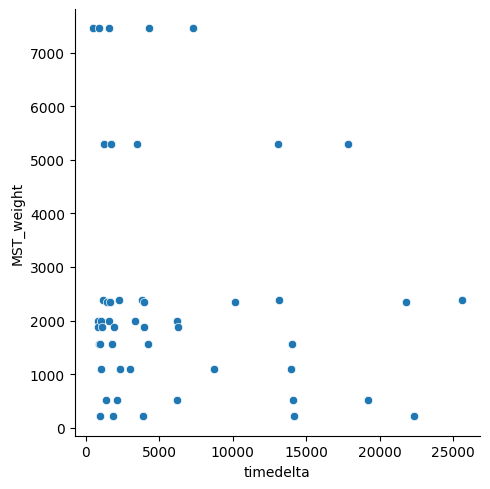

In [41]:
sns.relplot(y="MST_weight", x="timedelta", data=MCMC_rows)